### Importar bibliotecas

In [1]:
# Conexão com BigQuery
from google.cloud import bigquery
from google.oauth2 import service_account
# Manipulação de dados
import pandas as pd
import numpy as np
import warnings

### Criar conexão com os dados no GCP

In [2]:
# Realizar conexão com o GCP
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

### Criar dataframe com os dados já tratados e selecionados

In [3]:
# Os dados de mortalidade já foram tratados na ETL para calcular o YLL por cada óbito
# Aqui esta importação já está trazendo a taxa média do YLL dos municípios de médio porte por quedrimestre
consulta_sql = """
select
  a.quadrimestre,
  avg(a.taxa_yll) as taxa_media_yll
from (
with yll_quadrimestral as (
	select
		case
			when extract(month from y.dt_obito) between 1 and 4 then date(extract(year from y.dt_obito), 4, 30)
			when extract(month from y.dt_obito) between 5 and 8 then date(extract(year from y.dt_obito), 8, 31)
			when extract(month from y.dt_obito) between 9 and 12 then date(extract(year from y.dt_obito), 12, 31)
			end as quadrimestre,
		m.nm_municipio,
		p.populacao,
		sum(y.yll) as soma_yll
	from `ml-na-saude.yll_por_obito.yll` y
	join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
	join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
	where p.porte = 'Médio Porte'
    group by 1,2,3
)
select
	quadrimestre,
	nm_municipio,
  soma_yll,
  populacao,
  soma_yll / populacao * 1000 as taxa_yll
from yll_quadrimestral
group by 1,2,3,4
) a
group by 1
order by 1
"""

In [4]:
# Ignorar avisos e gerar dataframe
warnings.simplefilter("ignore")
df = client.query(consulta_sql).to_dataframe()

In [5]:
df.head()

,quadrimestre,taxa_media_yll
0,2010-04-30,6.427726
1,2010-08-31,6.767661
2,2010-12-31,6.111099
3,2011-04-30,6.550037
4,2011-08-31,6.878076


In [6]:
df.dtypes

quadrimestre       dbdate
taxa_media_yll    float64
dtype: object

### Cópia do DataFrame para manipulação e criação dos modelos

In [7]:
# Copiar dataframe para manipular dados
time_series = df.copy()

In [8]:
# Transformando o quadrimestre em data
time_series['quadrimestre'] = pd.to_datetime(time_series['quadrimestre'])

In [9]:
time_series.dtypes

quadrimestre      datetime64[ns]
taxa_media_yll           float64
dtype: object

In [10]:
time_series

,quadrimestre,taxa_media_yll
0,2010-04-30,6.427726
1,2010-08-31,6.767661
2,2010-12-31,6.111099
3,2011-04-30,6.550037
4,2011-08-31,6.878076
5,2011-12-31,5.804813
6,2012-04-30,6.280719
7,2012-08-31,6.739170
8,2012-12-31,6.049970
9,2013-04-30,6.253954


### Modelo

MAE: 0.4294878833155088
MSE: 0.26328475446860566
RMSE: 0.5131128087161786
MAPE: 0.06701199035970883
TU: 0.5869941562892818


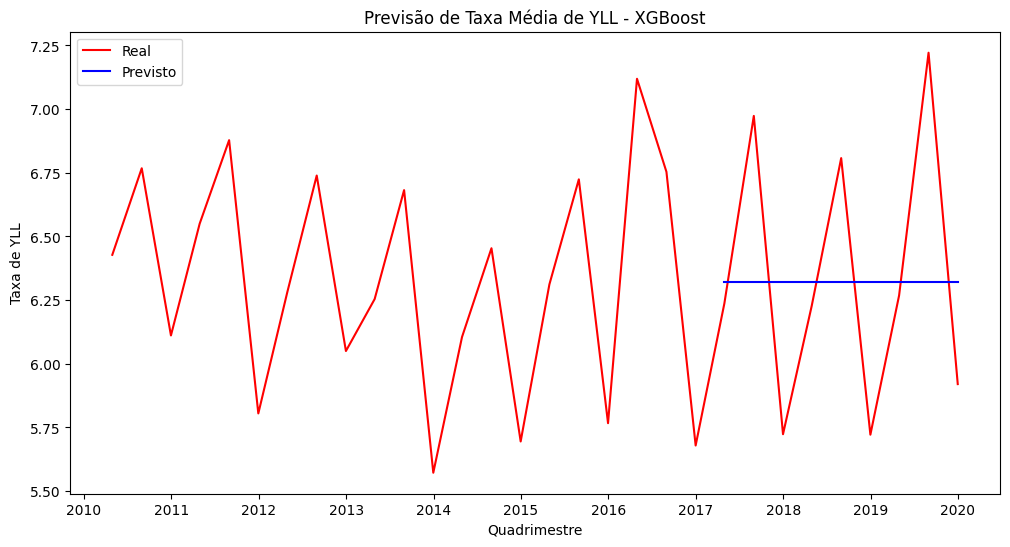

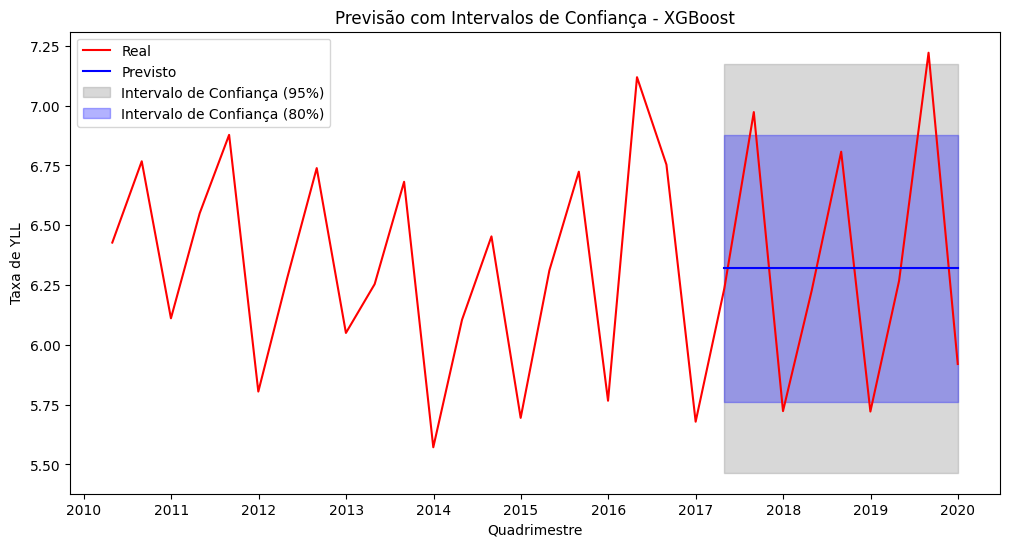

In [14]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

# Preparação dos dados
time_series['quadrimestre_num'] = time_series['quadrimestre'].dt.year * 4 + time_series['quadrimestre'].dt.month // 4  # Transformar quadrimestre em valor numérico
X = time_series[['quadrimestre_num']]  # Features
y = time_series['taxa_media_yll']  # Target

# Divisão dos dados em treino e teste (usando a divisão por data, onde 2017 em diante é o teste)
train = time_series[time_series['quadrimestre'] < '2017-01-01']
test = time_series[time_series['quadrimestre'] >= '2017-01-01']

X_train = train[['quadrimestre_num']]
y_train = train['taxa_media_yll']
X_test = test[['quadrimestre_num']]
y_test = test['taxa_media_yll']

# Treinamento do modelo XGBoost
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1, max_depth=5, alpha=10, n_estimators=1000)
xg_reg.fit(X_train, y_train)

# Previsão do modelo (apenas para o período de teste)
y_pred_test = xg_reg.predict(X_test)

# Cálculo das métricas de erro
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred_test)

# Calcular o erro Theil U2 (precisa de uma função customizada)
def theil_u2(actual, predicted):
    numerator = np.sum((actual - predicted) ** 2)
    denominator = np.sum((actual - np.roll(actual, 1)) ** 2) + np.sum((predicted - np.roll(predicted, 1)) ** 2)
    return np.sqrt(numerator / denominator)

tu = theil_u2(y_test, y_pred_test)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'TU: {tu}')

# Plotando os dados reais de toda a série e os dados previstos apenas para o período de teste
plt.figure(figsize=(12, 6))
plt.plot(time_series['quadrimestre'], time_series['taxa_media_yll'], label='Real', color='red')  # Dados reais
plt.plot(test['quadrimestre'], y_pred_test, label='Previsto', color='blue')  # Dados previstos apenas para o teste
plt.title('Previsão de Taxa Média de YLL - XGBoost')
plt.xlabel('Quadrimestre')
plt.ylabel('Taxa de YLL')
plt.legend()
plt.show()

# Intervalos de confiança
alpha_95 = 0.05  # Nível de significância para 95%
alpha_80 = 0.2  # Nível de significância para 80%

# Intervalo de confiança com base na previsão do modelo
forecast_mean = y_pred_test
forecast_std = np.std(y_train)  # Desvio padrão dos dados de treinamento

z_critical_95 = stats.norm.ppf(1 - alpha_95 / 2)
z_critical_80 = stats.norm.ppf(1 - alpha_80 / 2)

# Calcular intervalos de confiança
lower_bound_95 = forecast_mean - z_critical_95 * forecast_std
upper_bound_95 = forecast_mean + z_critical_95 * forecast_std

lower_bound_80 = forecast_mean - z_critical_80 * forecast_std
upper_bound_80 = forecast_mean + z_critical_80 * forecast_std

# Plotando com os intervalos de confiança apenas para o período de teste
plt.figure(figsize=(12, 6))
plt.plot(time_series['quadrimestre'], time_series['taxa_media_yll'], label='Real', color='red')  # Dados reais
plt.plot(test['quadrimestre'], y_pred_test, label='Previsto', color='blue')  # Dados previstos apenas para o teste
plt.fill_between(test['quadrimestre'], lower_bound_95, upper_bound_95, color='gray', alpha=0.3, label='Intervalo de Confiança (95%)')
plt.fill_between(test['quadrimestre'], lower_bound_80, upper_bound_80, color='blue', alpha=0.3, label='Intervalo de Confiança (80%)')
plt.title('Previsão com Intervalos de Confiança - XGBoost')
plt.xlabel('Quadrimestre')
plt.ylabel('Taxa de YLL')
plt.legend()
plt.show()


In [15]:
from sklearn.model_selection import GridSearchCV

# Definir os parâmetros para a busca
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [500, 1000, 1500],
}

# Criar o modelo XGBoost
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', alpha=10)

# Realizar a busca com validação cruzada
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3, verbose=1, n_jobs=-1)

# Ajustar o modelo
grid_search.fit(X_train, y_train)

# Melhor combinação de parâmetros
print(f'Best parameters: {grid_search.best_params_}')

# Previsões com o melhor modelo
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)

# Calcular as métricas de erro
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred_test)
tu = theil_u2(y_test, y_pred_test)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'TU: {tu}')


Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.6}
MAE: 0.4294878833155088
MSE: 0.26328475446860566
RMSE: 0.5131128087161786
MAPE: 0.06701199035970883
TU: 0.5869941562892818


Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Melhores parâmetros: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 1000, 'subsample': 0.6}


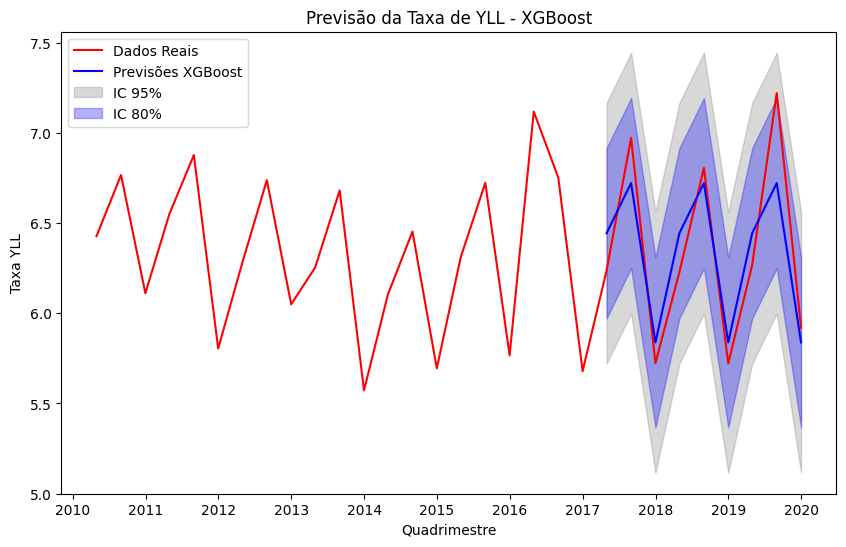

MAE: 0.19419700878960988
MSE: 0.05257534665674874
RMSE: 0.22929314568200407
MAPE: 0.029767627885653052
TU: 0.030609052668616802


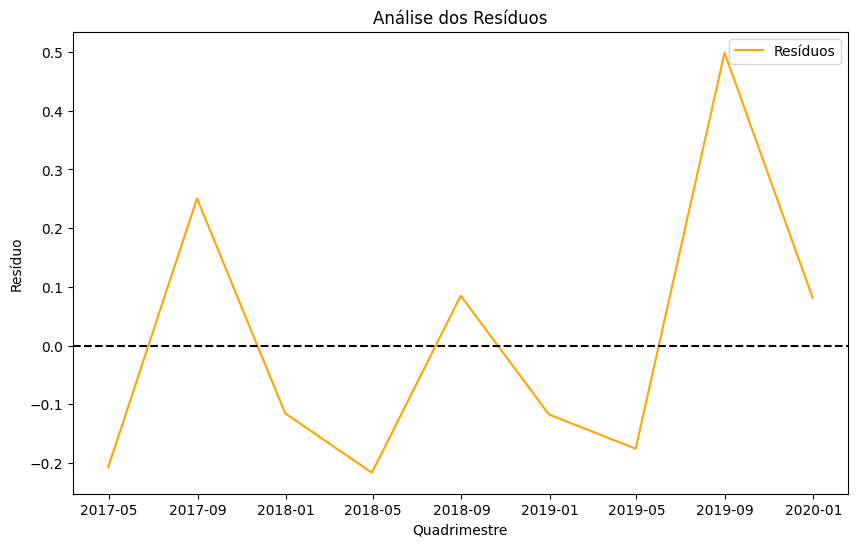

In [3]:
# Importações necessárias
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import numpy as np
import warnings
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Conexão com BigQuery
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# Carregar os dados
consulta_sql = """
select
  a.quadrimestre,
  avg(a.taxa_yll) as taxa_media_yll
from (
with yll_quadrimestral as (
	select
		case
			when extract(month from y.dt_obito) between 1 and 4 then date(extract(year from y.dt_obito), 4, 30)
			when extract(month from y.dt_obito) between 5 and 8 then date(extract(year from y.dt_obito), 8, 31)
			when extract(month from y.dt_obito) between 9 and 12 then date(extract(year from y.dt_obito), 12, 31)
			end as quadrimestre,
		m.nm_municipio,
		p.populacao,
		sum(y.yll) as soma_yll
	from `ml-na-saude.yll_por_obito.yll` y
	join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
	join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
	where p.porte = 'Médio Porte'
    group by 1,2,3
)
select
	quadrimestre,
	nm_municipio,
  soma_yll,
  populacao,
  soma_yll / populacao * 1000 as taxa_yll
from yll_quadrimestral
group by 1,2,3,4
) a
group by 1
order by 1
"""
# Ignorar avisos
warnings.simplefilter("ignore")
df = client.query(consulta_sql).to_dataframe()

# Copiar o dataframe para manipulação e criação dos modelos
time_series = df.copy()

# Transformando o quadrimestre em data
time_series['quadrimestre'] = pd.to_datetime(time_series['quadrimestre'])

# Separando as variáveis dependentes e independentes
X = time_series.drop(columns=['quadrimestre', 'taxa_media_yll'])
y = time_series['taxa_media_yll']

# Dividindo em treino e teste (usando os últimos 3 anos como teste)
train = time_series.loc[:'2016-12-31']
test = time_series.loc['2017-01-01':]

# Feature Engineering: Sazonalidade com funções trigonométricas para quadrimestres
train['quadrimestre_sin'] = np.sin(2 * np.pi * train['quadrimestre'].dt.month / 12)
train['quadrimestre_cos'] = np.cos(2 * np.pi * train['quadrimestre'].dt.month / 12)
test['quadrimestre_sin'] = np.sin(2 * np.pi * test['quadrimestre'].dt.month / 12)
test['quadrimestre_cos'] = np.cos(2 * np.pi * test['quadrimestre'].dt.month / 12)

# XGBoost com GridSearchCV para ajuste de parâmetros
xgb_model = xgb.XGBRegressor()

# Parâmetros a serem ajustados
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 2, 3]
}

# Aplicando GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)
grid_search.fit(train[['quadrimestre_sin', 'quadrimestre_cos']], train['taxa_media_yll'])

# Melhores parâmetros encontrados
best_params = grid_search.best_params_
print(f"Melhores parâmetros: {best_params}")

# Treinando o modelo com os melhores parâmetros
xgb_best = xgb.XGBRegressor(**best_params)
xgb_best.fit(train[['quadrimestre_sin', 'quadrimestre_cos']], train['taxa_media_yll'])

# Fazendo previsões
predictions = xgb_best.predict(test[['quadrimestre_sin', 'quadrimestre_cos']])

# Plotando os resultados
plt.figure(figsize=(10,6))
plt.plot(time_series['quadrimestre'], time_series['taxa_media_yll'], label='Dados Reais', color='red')
plt.plot(test['quadrimestre'], predictions, label='Previsões XGBoost', color='blue')
plt.fill_between(test['quadrimestre'], predictions - 1.96*np.std(predictions), predictions + 1.96*np.std(predictions), color='gray', alpha=0.3, label='IC 95%')
plt.fill_between(test['quadrimestre'], predictions - 1.28*np.std(predictions), predictions + 1.28*np.std(predictions), color='blue', alpha=0.3, label='IC 80%')
plt.title('Previsão da Taxa de YLL - XGBoost')
plt.xlabel('Quadrimestre')
plt.ylabel('Taxa YLL')
plt.legend()
plt.show()

# Calculando as métricas de erro
mae = mean_absolute_error(test['taxa_media_yll'], predictions)
mse = mean_squared_error(test['taxa_media_yll'], predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test['taxa_media_yll'], predictions)

# Como TU não é uma função padrão do sklearn, vamos definir um cálculo simples para Theil U2
def theil_u2(actual, predicted):
    return np.mean(np.abs(actual - predicted)) / np.mean(np.abs(actual))

tu = theil_u2(test['taxa_media_yll'], predictions)

# Exibindo os resultados
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'TU: {tu}')

# Analisando resíduos
residuals = test['taxa_media_yll'] - predictions
plt.figure(figsize=(10,6))
plt.plot(test['quadrimestre'], residuals, label='Resíduos', color='orange')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Análise dos Resíduos')
plt.xlabel('Quadrimestre')
plt.ylabel('Resíduo')
plt.legend()
plt.show()
